# 1. Initalization

In [102]:
import pandas as pd
import numpy as np
from pathlib import Path

project_root = Path.cwd().resolve().parent
data_dir = project_root / "data"

# Import MSTR
mstr = pd.read_csv(
    "../data/MSTR.csv",
    header=2,
    parse_dates=["Date"],
    date_format="%Y-%m-%d",
    index_col="Date"
)

mstr.columns = ["Close", "High", "Low", "Open", "Volume"]
mstr.sort_index(inplace=True)
mstr.index = pd.to_datetime(mstr.index)


# Import BTC-USD
btc = pd.read_csv(
    "../data/BTC-USD.csv",
    header=2,
    parse_dates=["Date"],
    date_format="%Y-%m-%d",
    index_col="Date"
)

btc.columns = ["Close", "High", "Low", "Open", "Volume"]
btc.sort_index(inplace=True)
btc.index = pd.to_datetime(btc.index)
btc = btc.reindex(mstr.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-08-13 to 2025-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1826 non-null   float64
 1   High    1826 non-null   float64
 2   Low     1826 non-null   float64
 3   Open    1826 non-null   float64
 4   Volume  1826 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


<Axes: xlabel='Date'>

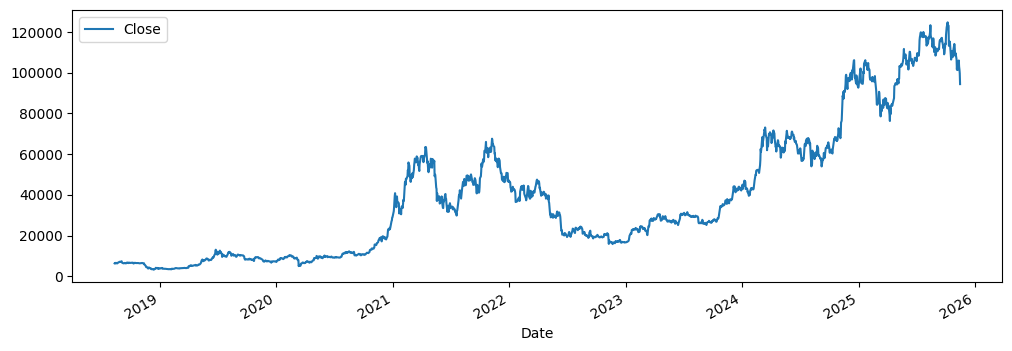

In [103]:
btc.info()
btc.describe()
btc.isna().sum()
btc.plot(y="Close", figsize=(12,4))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-08-13 to 2025-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1826 non-null   float64
 1   High    1826 non-null   float64
 2   Low     1826 non-null   float64
 3   Open    1826 non-null   float64
 4   Volume  1826 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


<Axes: xlabel='Date'>

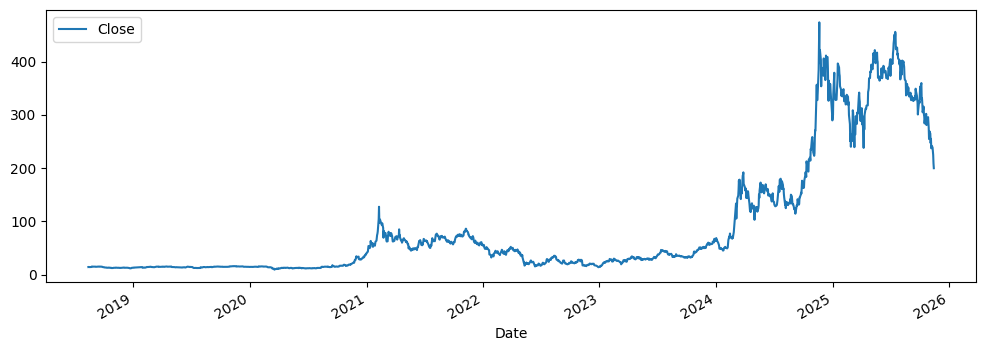

In [104]:
mstr.info()
mstr.describe()
mstr.isna().sum()
mstr.plot(y="Close", figsize=(12,4))

<Axes: title={'center': 'BTC Close vs EMA21 vs Quarterly VWAP'}, xlabel='Date'>

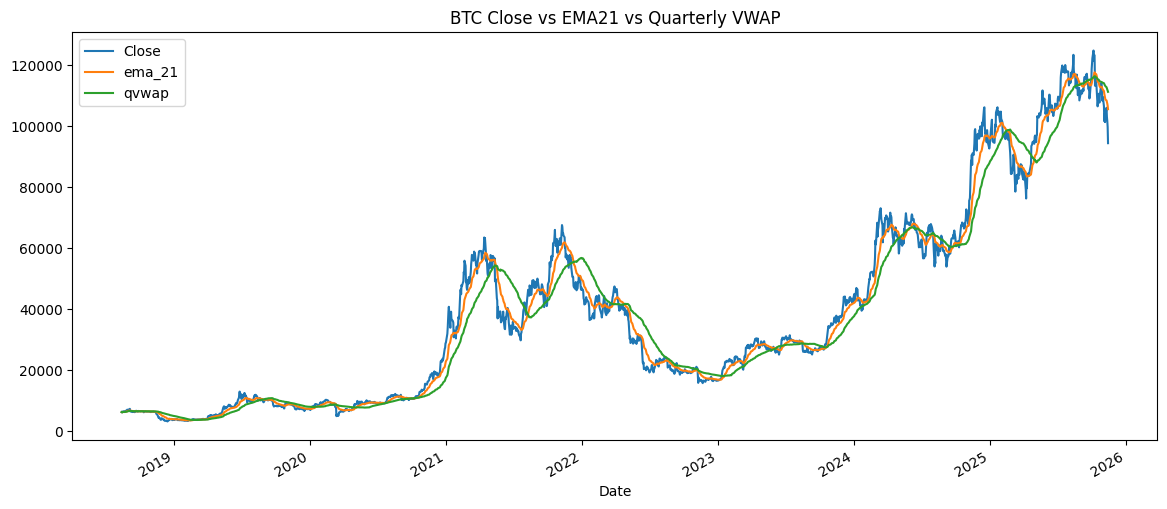

In [105]:
# Bitcoin
btc["log_ret"] = np.log(btc["Close"]).diff()

# EMA 21
btc["ema_21"] = btc["Close"].ewm(span=21).mean()

# Quarterly VWAP
btc["qvwap"] = (
    (btc["Close"] * btc["Volume"]).rolling("90D").sum()
    / btc["Volume"].rolling("90D").sum()
)

# Standarized log return
window=30
rolling_mean = btc["log_ret"].rolling(window).mean()
rolling_std = btc["log_ret"].rolling(window).std()
btc["z_log_ret"] = (btc["log_ret"]-rolling_mean)/rolling_std

btc[["Close", "ema_21", "qvwap"]].plot(
    figsize=(14,6),
    title="BTC Close vs EMA21 vs Quarterly VWAP"
)

<Axes: title={'center': 'BTC Standardized Log-Returns (30-Day Window)'}, xlabel='Date'>

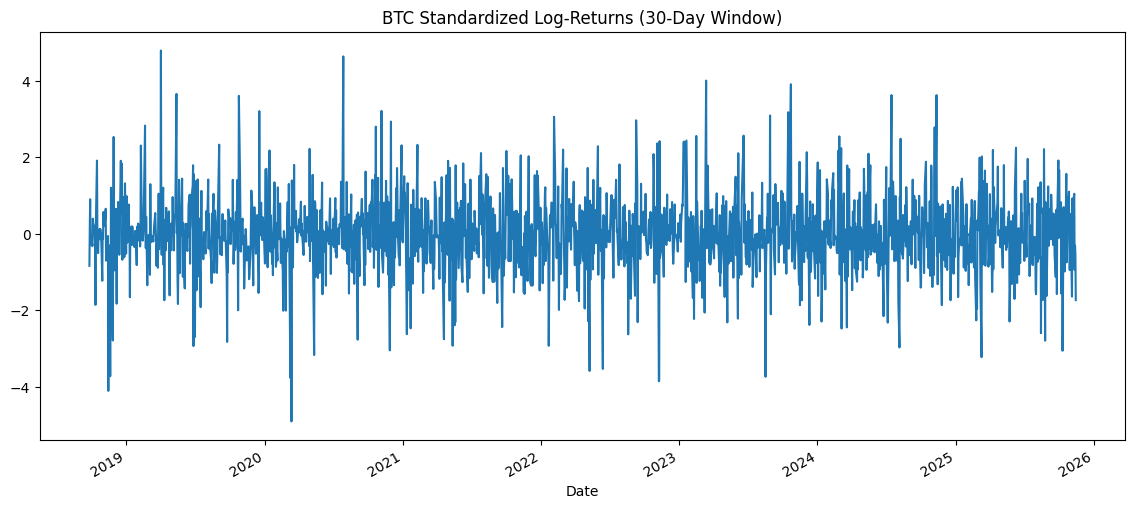

In [106]:
btc["z_log_ret"].plot(
    figsize=(14,6),
    title="BTC Standardized Log-Returns (30-Day Window)"
)

<Axes: title={'center': 'MSTR Close vs EMA21 vs Quarterly VWAP'}, xlabel='Date'>

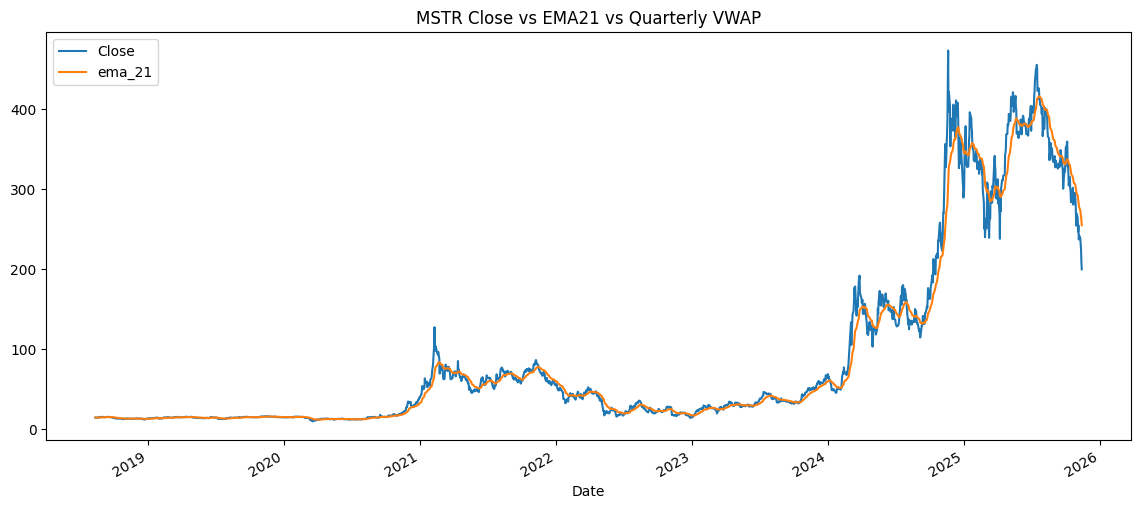

In [107]:
# MSTR
mstr["log_ret"] = np.log(mstr["Close"]).diff()

# EMA 21
mstr["ema_21"] = mstr["Close"].ewm(span=21).mean()

# Quarterly VWAP
# mstr["qvwap"] = (
#     (mstr["Close"] * mstr["Volume"]).rolling("90D").sum()
#     / mstr["Volume"].rolling("90D").sum()
# )

# Standarized log return
window=30
rolling_mean = mstr["log_ret"].rolling(window).mean()
rolling_std = mstr["log_ret"].rolling(window).std()
mstr["z_log_ret"] = (mstr["log_ret"]-rolling_mean)/rolling_std

mstr[["Close", "ema_21"]].plot(
    figsize=(14,6),
    title="MSTR Close vs EMA21 vs Quarterly VWAP"
)


<Axes: title={'center': 'MSTR Standardized Log-Returns (30-Day Window)'}, xlabel='Date'>

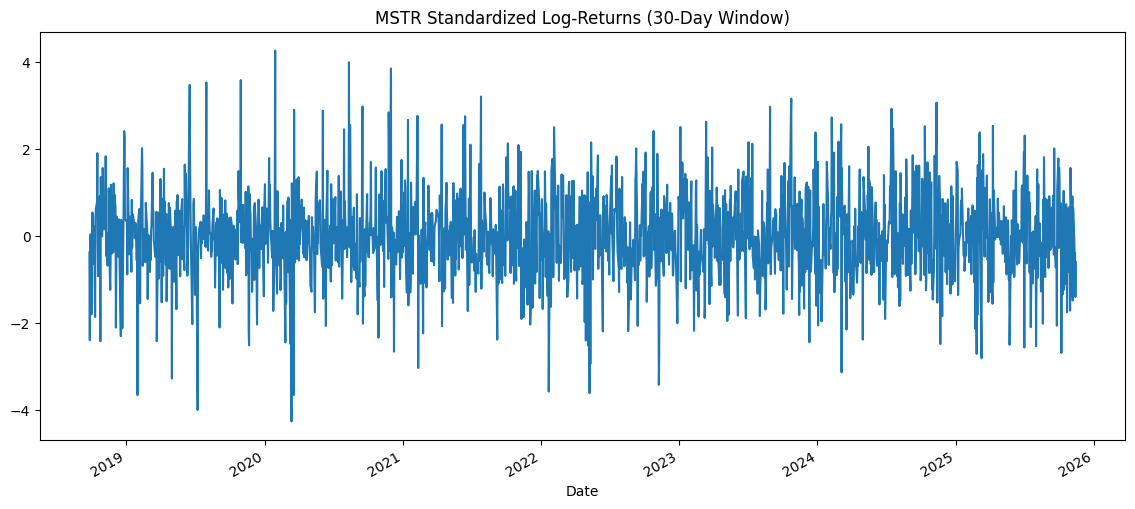

In [108]:
mstr["z_log_ret"].plot(
    figsize=(14,6),
    title="MSTR Standardized Log-Returns (30-Day Window)"
)

# 2. Correlation?

In [112]:
print(btc.index.dtype, btc.index[:3])
print(mstr.index.dtype, mstr.index[:3])


datetime64[ns] DatetimeIndex(['2018-08-13', '2018-08-14', '2018-08-15'], dtype='datetime64[ns]', name='Date', freq=None)
datetime64[ns] DatetimeIndex(['2018-08-13', '2018-08-14', '2018-08-15'], dtype='datetime64[ns]', name='Date', freq=None)


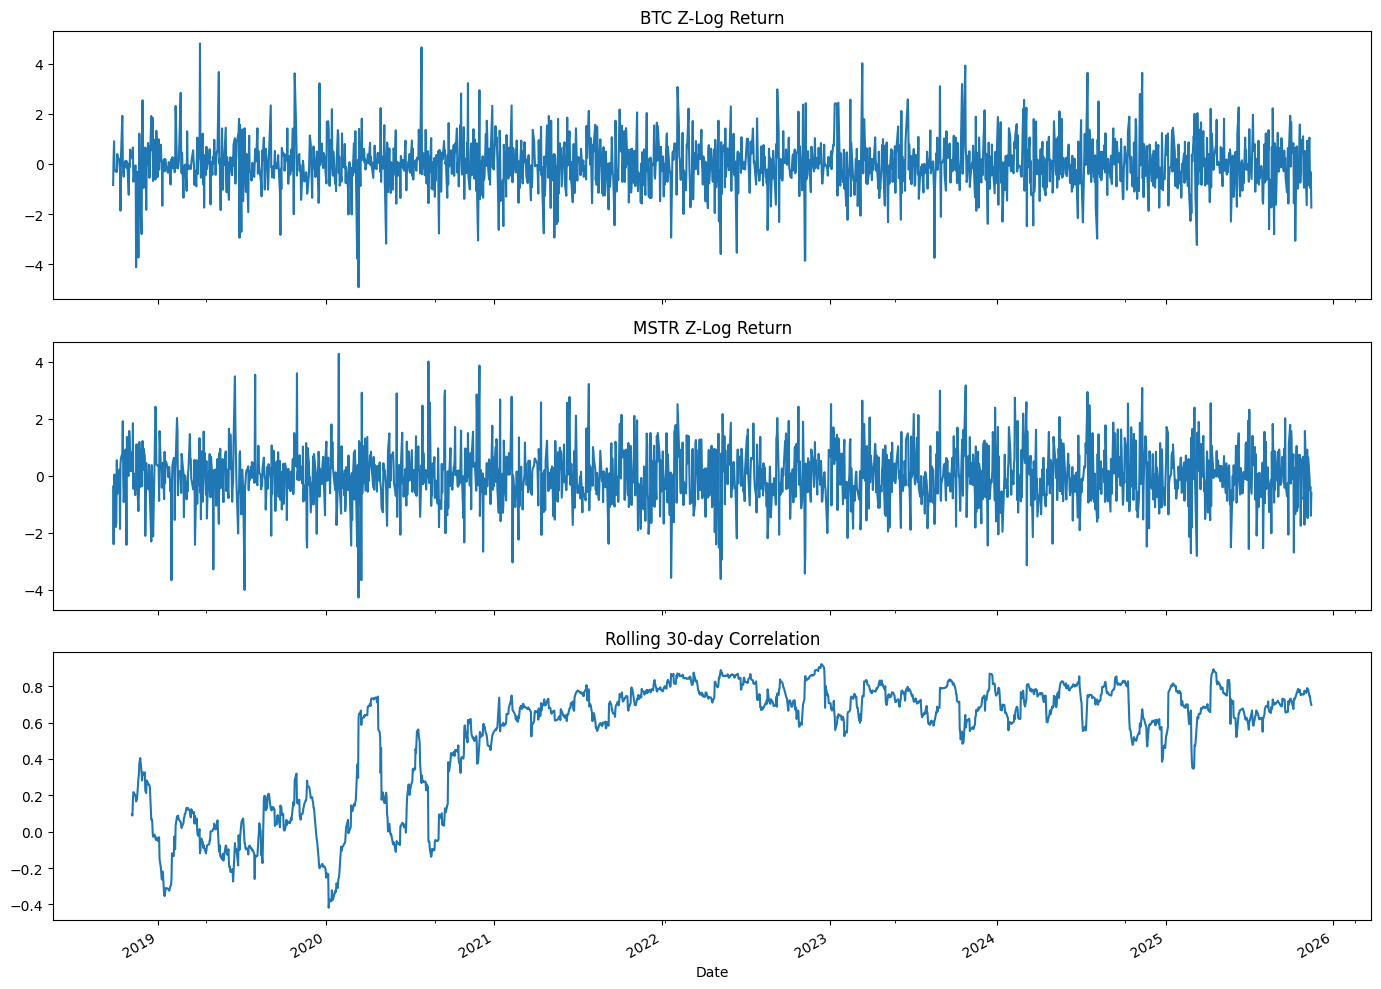

In [ ]:
# 30 day rolling correlation between assets
corr = btc["z_log_ret"].rolling(30).corr(mstr["z_log_ret"])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

btc["z_log_ret"].plot(ax=axs[0], title="BTC Z-Log Return")
mstr["z_log_ret"].plot(ax=axs[1], title="MSTR Z-Log Return")
corr.plot(ax=axs[2], title="Rolling 30-day Correlation")

plt.tight_layout()


# Spread

<Axes: title={'center': 'Z-Score Spread (MSTR-BTC)'}, xlabel='Date'>

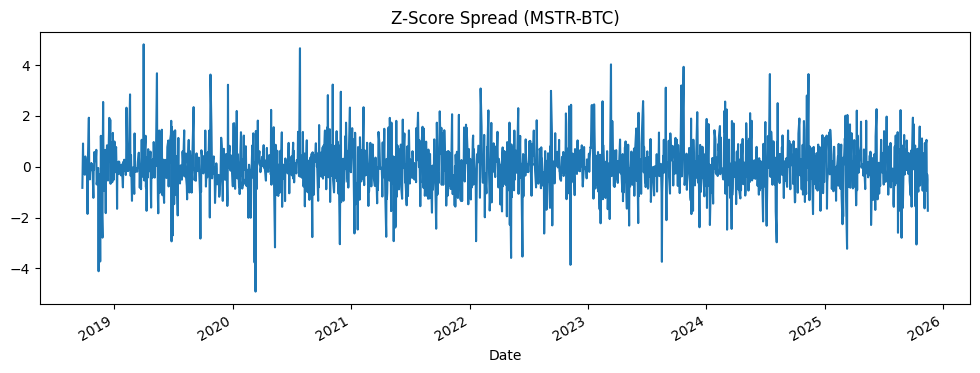

In [116]:
spread = mstr["z_log_ret"] = btc["z_log_ret"]
spread.plot(figsize=(12, 4), title="Z-Score Spread (MSTR-BTC)")